# 概要
irisのデータを使ってデータ解析をする。

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_ind

sns.set(font='IPAPGothic', style='whitegrid')

In [2]:
iris = datasets.load_iris()

irisのデータはsepal(萼片)の全長と幅とpetal(花弁)の全長と幅からなる。

In [3]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

対象となるirisは三種類

In [4]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], 
      dtype='<U10')

# 基本集計
データの性質を見るために簡単に集計を行う。

In [5]:
x = pd.DataFrame(iris.data, columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
y = pd.Series(iris.target, name='label')
y_str = pd.Series(iris.target, name='slabel').apply(lambda x: iris.target_names[x])
df = pd.concat([x, y, y_str], axis=1)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label,slabel
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


各ラベルごとの平均、分散などを調べる

In [6]:
df.groupby('label').describe()

petal_length  petal_width  sepal_length  sepal_width
label                                                            
0     count     50.000000    50.000000     50.000000    50.000000
      mean       1.464000     0.244000      5.006000     3.418000
      std        0.173511     0.107210      0.352490     0.381024
      min        1.000000     0.100000      4.300000     2.300000
      25%        1.400000     0.200000      4.800000     3.125000
      50%        1.500000     0.200000      5.000000     3.400000
      75%        1.575000     0.300000      5.200000     3.675000
      max        1.900000     0.600000      5.800000     4.400000
1     count     50.000000    50.000000     50.000000    50.000000
      mean       4.260000     1.326000      5.936000     2.770000
      std        0.469911     0.197753      0.516171     0.313798
      min        3.000000     1.000000      4.900000     2.000000
      25%        4.000000     1.200000      5.600000     2.525000
      50%        4.350000     1.300000      5.900000     2.800000
      75%        4.600000     1.500000      6.300000     3.000000
      max        5.100000     1.800000      7.000000     3.400000
2     count     50.000000    50.000000     50.000000    50.000000
      mean       5.552000     2.026000      6.588000     2.974000
      std        0.551895     0.274650      0.635880     0.322497
      min        4.500000     1.400000      4.900000     2.200000
      25%        5.100000     1.800000      6.225000     2.800000
      50%        5.550000     2.000000      6.500000     3.000000
      75%        5.875000     2.300000      6.900000     3.175000
      max        6.900000     2.500000      7.900000     3.800000

sebornのlmplotを使って萼片と花弁の長さの分布を出してみる。
hueオプションでlabelごとに色を変えている。また、fit_reg=Falseにすることで線形回帰させないようにしている。

/Users/ken/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


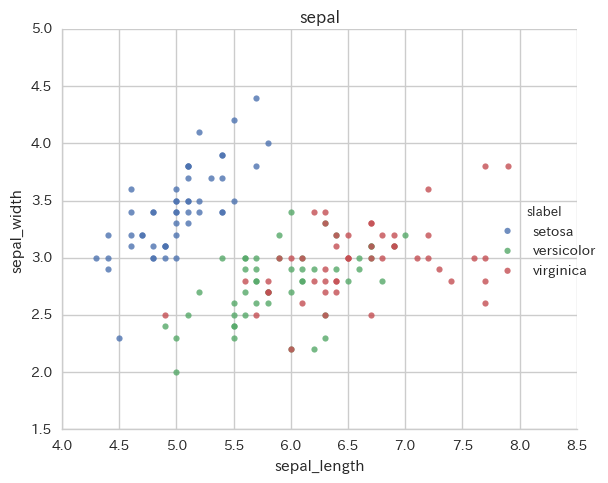

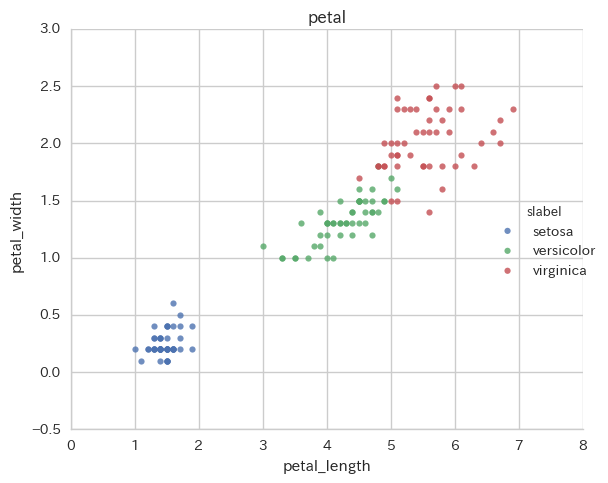

In [7]:
sns.lmplot('sepal_length', 'sepal_width', df, hue='slabel', fit_reg=False)
plt.title('sepal')
sns.lmplot('petal_length', 'petal_width', df, hue='slabel', fit_reg=False)
plt.title('petal')

全ての組み合わせを出したい場合は、pairplotを使うと簡単

/Users/ken/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


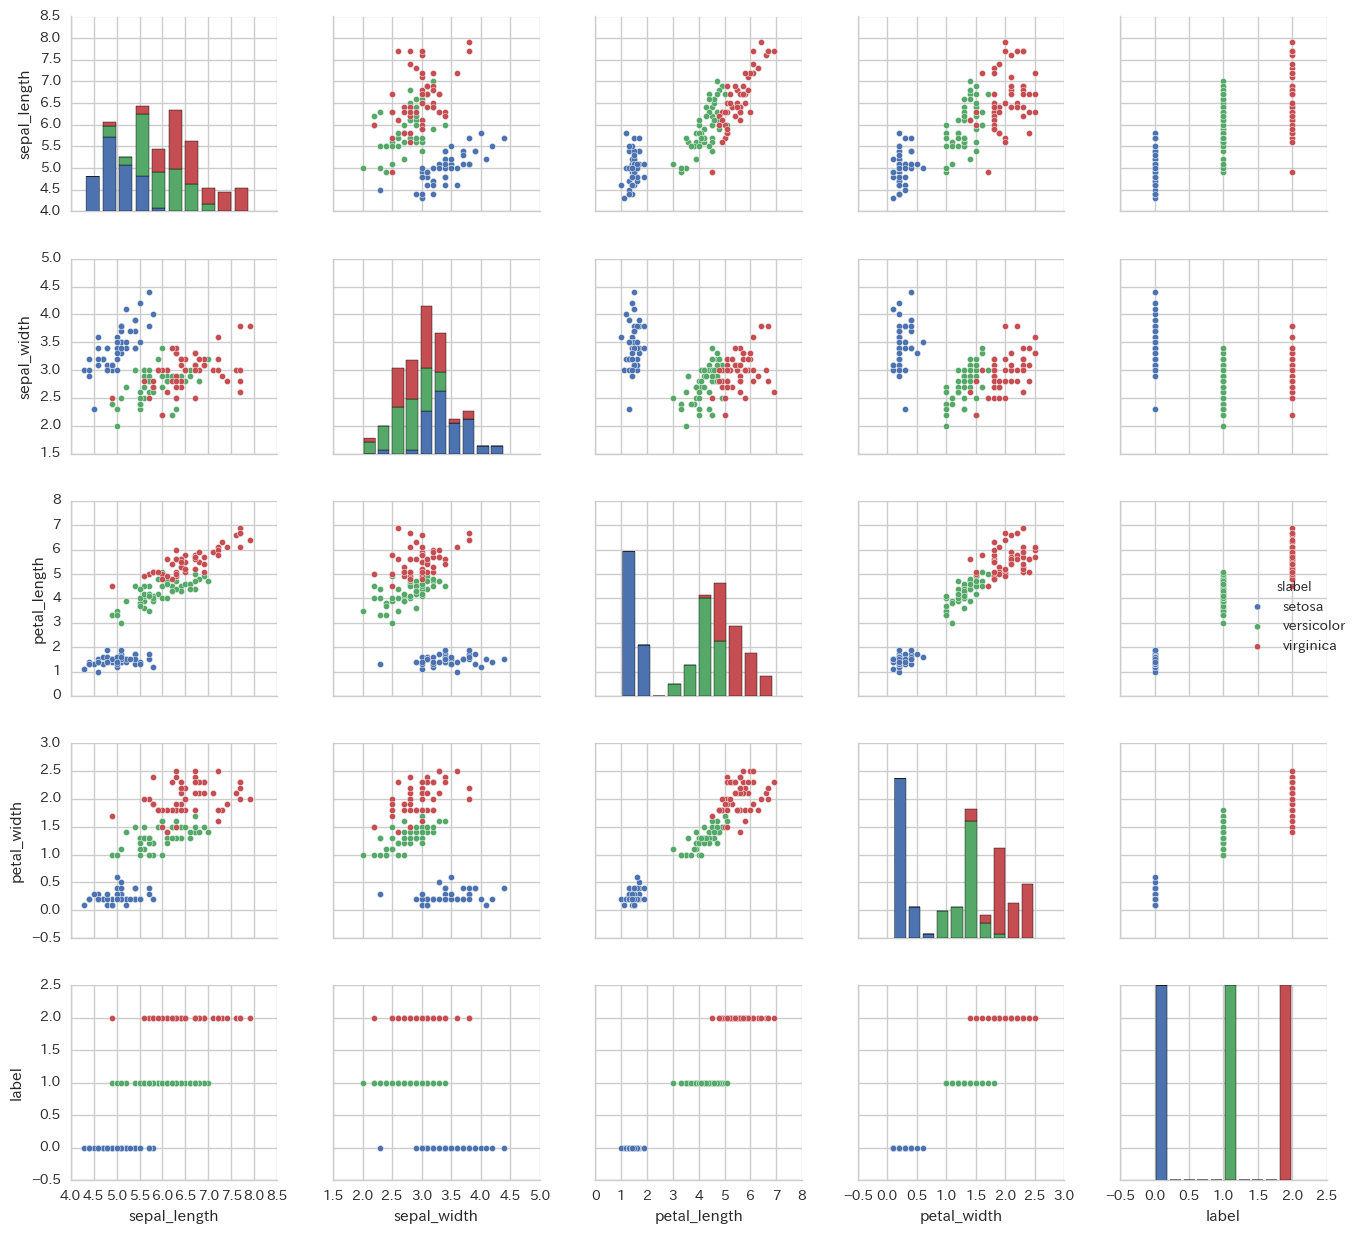

In [8]:
sns.pairplot(df, hue='slabel')

# t検定
t検定で萼片や花弁の有意差を検定してみる。
itertoolsのcombinations関数は、リストから要素の組み合わせを作ることができる。

In [9]:
for l1, l2 in it.combinations(iris.target_names, 2):
    for f in x.columns:
        print(l1, l2, f)
        t, p = ttest_ind(df[df.slabel == l1][f], df[df.slabel == l2][f])
        print("p = %f" % p)

setosa versicolor sepal_length
p = 0.000000
setosa versicolor sepal_width
p = 0.000000
setosa versicolor petal_length
p = 0.000000
setosa versicolor petal_width
p = 0.000000
setosa virginica sepal_length
p = 0.000000
setosa virginica sepal_width
p = 0.000000
setosa virginica petal_length
p = 0.000000
setosa virginica petal_width
p = 0.000000
versicolor virginica sepal_length
p = 0.000000
versicolor virginica sepal_width
p = 0.001819
versicolor virginica petal_length
p = 0.000000
versicolor virginica petal_width
p = 0.000000


# 機械学習
機械学習を色々試してみる。

## 様々な学習モデル
### 単純パーセプトロン
#### 2値分類
パーセプトロンを用いた学習を行ってみる。まずは可視化を簡単にするためlabelを0,1に限定しpetal_lengthとpetal_widthのみを利用して学習を行ってみる。
まずはトレーニングデータとテストデータを分割する。

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x[df.label.isin((0, 1))], y[df.label.isin((0, 1))])
net = perceptron.Perceptron()
net.fit(x_train[['petal_length', 'petal_width']], y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

テストデータに対して精度を計算してみる。

In [11]:
accuracy_score(y_true=net.predict(x_test[['petal_length', 'petal_width']]), y_pred=y_test)

1.0

二軸を使って分類を可視化してみる

In [12]:
_, _, x_max, y_max, = x_train.max() + .5
_, _, x_min, y_min = x_train.min() - .5

meshgridは座標を作成するメソッド。グリッド状に分割した点を作成するために使用する。

In [13]:
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))

ravel関数で二次元配列を1次元配列にし、`np.c_`で同じindexとなる値を結合して座標の配列を作成できる。

In [14]:
np.c_[xx.ravel(), yy.ravel()]

array([[ 0.5       , -0.4       ],
       [ 0.50510511, -0.4       ],
       [ 0.51021021, -0.4       ],
       ..., 
       [ 5.58978979,  2.3       ],
       [ 5.59489489,  2.3       ],
       [ 5.6       ,  2.3       ]])

これが一つ一つの座標となるので、一つ一つの座標に対しどちらのラベルが振られるかをpredictする。

In [15]:
z = net.predict(np.c_[xx.ravel(), yy.ravel()])

contourfは塗りつぶしとなる等高線

/Users/ken/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


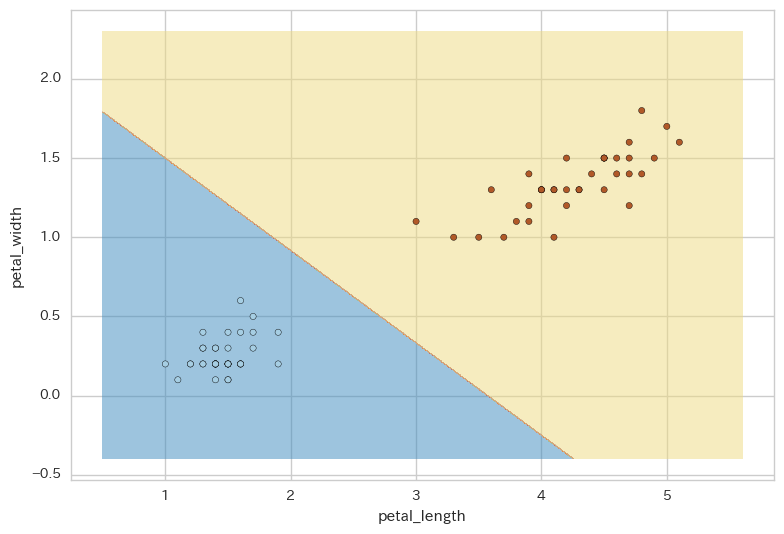

In [16]:
plt.contourf(xx, yy, z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(x_train.petal_length, x_train.petal_width, c=y_train, cmap=plt.cm.Paired)
plt.xlabel('petal_length')
plt.ylabel('petal_width')

#### 3値分類
次は3値分類を行う。

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y)
net = perceptron.Perceptron()
net.fit(x_train[['petal_length', 'petal_width']], y_train)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [18]:
accuracy_score(y_true=net.predict(x_test[['petal_length', 'petal_width']]), y_pred=y_test)

0.71052631578947367

In [19]:
_, _, x_max, y_max, = x_train.max() + .5
_, _, x_min, y_min = x_train.min() - .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
z = net.predict(np.c_[xx.ravel(), yy.ravel()])

/Users/ken/.pyenv/versions/3.5.2/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


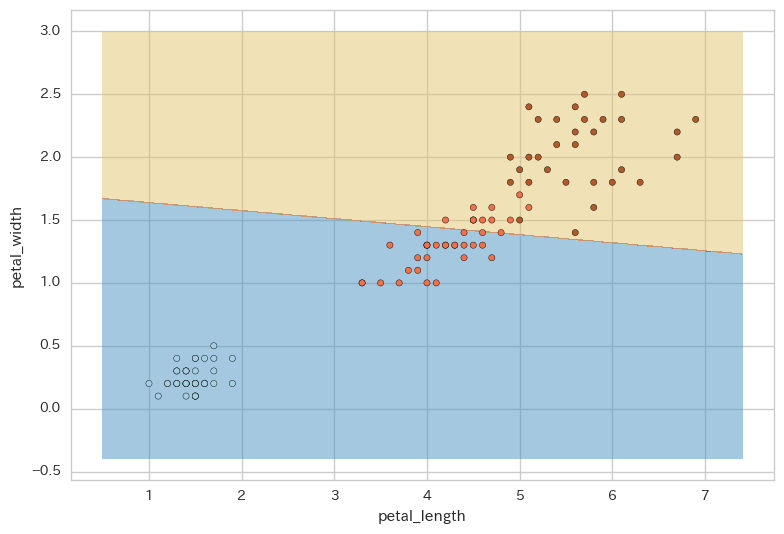

In [20]:
plt.contourf(xx, yy, z.reshape(xx.shape), cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(x_train.petal_length, x_train.petal_width, c=y_train, cmap=plt.cm.Paired)
plt.xlabel('petal_length')
plt.ylabel('petal_width')

あまり分類がうまく行っていないことが分かる。

#### 説明変数を増やす
学習にpetal_length、petal_widthのみしか使ってなかったことが精度を上げられない原因と考えられる。
よって、説明変数にsepalも加えてみる。

In [21]:
net = perceptron.Perceptron()
net.fit(x_train, y_train)
accuracy_score(y_true=net.predict(x_test), y_pred=y_test)

0.71052631578947367

#### 繰り返し数を増やしeta0を減らす

In [22]:
net = perceptron.Perceptron(n_iter=1000, eta0=0.01)
net.fit(x_train, y_train)
accuracy_score(y_true=net.predict(x_test), y_pred=y_test)

0.89473684210526316

このようにパラメータを変更することで結果が大きく変わってくる。

### ロジスティック回帰
ロジスティック回帰による分類も行ってみる。

In [23]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
accuracy_score(y_true=y_test, y_pred=lr.predict(x_test))

0.92105263157894735

### SVM
サポートベクターマシンによる分類。

In [24]:
svc = SVC()
svc.fit(x_train, y_train)
accuracy_score(y_true=y_test, y_pred=lr.predict(x_test))

0.92105263157894735

### ランダムフォレスト

In [25]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
accuracy_score(y_true=y_test, y_pred=lr.predict(x_test))

0.92105263157894735

## クロスバリデーション
単純、パーセプトロン、ロジスティック回帰、SVM、ランダムフォレストなどの例を見てもらえればわかるように、
scikit-learnでは機械学習のメソッドが統一フォーマットで使いやすくなっている。
sklearnによる機械学習の流れは以下の通り

- モデル初期化(perceptron.Perceptron(), LogisticRegression(), SVC(), RandomForestClassifier()など)
- トレーニングデータからfitting(net.fit, lr.fit, svc.fit, rfc.fit)
- テストデータに予測モデルを適用し予測を行う(net.predict, lr.predictなど, svc.predict, rfc.predictなど)

sklearnは非常に便利なクロスバリデーションも用意している。
パラメータの設定などももちろんあるが、ここではパラメータを調整しない状態でクロスバリデーションをかけてみる。
クロスバリデーションは、cross_val_scoreを用いる。第一引数にモデルを指定し、第二引数、第三引数に、それぞれ説明変数、目的変数を指定し、cvオプションで何分割のクロスバリデーションにするかを設定する。
今回はfive-fold cross validationとする。

例えば、パーセプトロンでやる場合は以下のようになる。

In [26]:
net = perceptron.Perceptron()
cross_val_score(net, x, y, cv=5)

array([ 0.5       ,  0.56666667,  0.4       ,  0.73333333,  0.33333333])

各モデルを比較してみる。cross validationの結果の平均値を使って比較する。

In [27]:
net = perceptron.Perceptron()
lr = LogisticRegression()
svc = SVC()
rfc = RandomForestClassifier()
for cls in [net, lr, svc, rfc]:
    print(type(cls), cross_val_score(cls, x, y, cv=5).mean())

<class 'sklearn.linear_model.perceptron.Perceptron'> 0.506666666667
<class 'sklearn.linear_model.logistic.LogisticRegression'> 0.96
<class 'sklearn.svm.classes.SVC'> 0.98
<class 'sklearn.ensemble.forest.RandomForestClassifier'> 0.946666666667
